In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re  

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate

In [46]:
# All Time are in format of xx.00.00 so a simple regex can replace these all easily
def fixTime(timeGiven):
    return re.sub("\.00\.00", "", timeGiven)

# The problematic commas can all be replaced with a simple regex as well
def fixCommas(numberGiven):
    return re.sub(",", ".", numberGiven)

In [47]:
usecols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]  # There are two extra blank columns in the csv, this gets rid of them.
df = pd.read_csv(os.getcwd() + r'/data/AirQualityUCI.csv', 
                 delimiter=';', usecols=usecols)
df = df[~df['Time'].isna()] # Remove the large amount NaN rows - these were empty in the original data
df['Time'] = df['Time'].apply(fixTime) 
df = df.astype({'Time':'int32'}, copy=False) # From string to int32
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y') # Set 'Date' to actually be datetime with format
df['dTime'] = df['Date'] + pd.to_timedelta(df['Time'], unit='h') # Combine the 'Date' and 'Time' columns into 'dTime'
df.drop(columns=['Date', 'Time'], index=1, inplace=True) # Drop the original 'Date' and 'Time' columns
df.set_index('dTime', inplace=True)
# df[['Date', 'Time']] = df[['Date', 'Time']].apply(pd.to_datetime)
# df.head()

In [48]:
df["CO(GT)"] = df["CO(GT)"].apply(fixCommas)
df = df.astype({"CO(GT)":"float64"}, copy=False)

df["C6H6(GT)"] = df["C6H6(GT)"].apply(fixCommas)
df = df.astype({"C6H6(GT)":"float64"}, copy=False)

df["T"] = df["T"].apply(fixCommas)
df = df.astype({"T":"float64"}, copy=False)

df["RH"] = df["RH"].apply(fixCommas)
df = df.astype({"RH":"float64"}, copy=False)

df["AH"] = df["AH"].apply(fixCommas)
df = df.astype({"AH":"float64"}, copy=False)

In [49]:
df[df.isin([-200]).any(axis=1)]  # 91% of all rows contain at least 1 missing value marked by a -200
df = df.replace(-200, np.nan)  # Replace all of these -200 markers with a np.nan

In [50]:
def makeTimeFeatures(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    # df['year'] = df.index.year # Not required here, data range too small
    df['dayofyear'] = df.index.dayofyear
    return df

In [51]:
makeTimeFeatures(df)
df.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
dTime                                                                         
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   
2004-03-10 23:00:00     1.2       1197.0      38.0       4.7          750.0   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
dTime                                                               
2004-03-10 18:00:00    166.0        1056.0    113.0        1692.0   
2004-03-10 20:00:00    131.0        1140.0    114.0        1555.0   
2004-03-10 21:00:00    172.0        1092.0    122.0        1584.0   
2004-03-10 22:00:00    131.0        1205.0    116.0        1490.0   
2004-03-10 23:00:00     89.0        1337.0     96.0        1393.0   

                     PT08.S5(O3)     T    RH      AH  hour  dayofweek  \
dTime                                                                   
2004-03-10 18:00:00       1268.0  13.6  48.9  0.7578    18          2   
2004-03-10 20:00:00       1074.0  11.9  54.0  0.7502    20          2   
2004-03-10 21:00:00       1203.0  11.0  60.0  0.7867    21          2   
2004-03-10 22:00:00       1110.0  11.2  59.6  0.7888    22          2   
2004-03-10 23:00:00        949.0  11.2  59.2  0.7848    23          2   

                     quarter  month  dayofyear  
dTime                                           
2004-03-10 18:00:00        1      3         70  
2004-03-10 20:00:00        1      3         70  
2004-03-10 21:00:00        1      3         70  
2004-03-10 22:00:00        1      3         70  
2004-03-10 23:00:00        1      3         70

In [52]:
df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  7673.000000  8990.000000   913.000000  8990.000000    8990.000000   
mean      2.152769  1099.811791   218.928806    10.083181     939.151613   
std       1.453346   217.082649   204.541374     7.450231     266.846218   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.100000   937.000000    67.000000     4.400000     734.250000   
50%       1.800000  1063.000000   150.000000     8.200000     909.000000   
75%       2.900000  1231.000000   297.000000    14.000000    1116.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  7717.000000   8990.000000  7714.000000   8990.000000  8990.000000   
mean    246.915382    835.455951   113.093985   1456.253170  1022.911791   
std     212.986668    256.806784    48.372647    346.224354   398.506090   
min       2.000000    322.000000     2.000000    551.000000   221.000000   
25%      98.000000    658.000000    78.000000   1227.000000   731.250000   
50%     180.000000    806.000000   109.000000   1463.000000   963.000000   
75%     326.000000    969.000000   142.000000   1674.000000  1273.750000   
max    1479.000000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH         hour    dayofweek  \
count  8990.000000  8990.000000  8990.000000  9356.000000  9356.000000   
mean     18.318387    49.234372     1.025564    11.497755     3.010047   
std       8.832448    17.317848     0.403823     6.923117     2.000402   
min      -1.900000     9.200000     0.184700     0.000000     0.000000   
25%      11.800000    35.800000     0.736900     5.000000     1.000000   
50%      17.800000    49.600000     0.995500    11.000000     3.000000   
75%      24.400000    62.500000     1.313750    17.250000     5.000000   
max      44.600000    88.700000     2.231000    23.000000     6.000000   

           quarter        month    dayofyear  
count  9356.000000  9356.000000  9356.000000  
mean      2.422723     6.310710   177.307396  
std       1.134330     3.438173   105.230382  
min       1.000000     1.000000     1.000000  
25%       1.000000     3.000000    84.000000  
50%       2.000000     6.000000   172.000000  
75%       3.000000     9.000000   269.000000  
max       4.000000    12.000000   366.000000

In [53]:
df.isnull().sum(axis=0).keys()

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'hour', 'dayofweek', 'quarter', 'month', 'dayofyear'],
      dtype='object')

Text(0.5, 1.0, 'Missing values for each column')

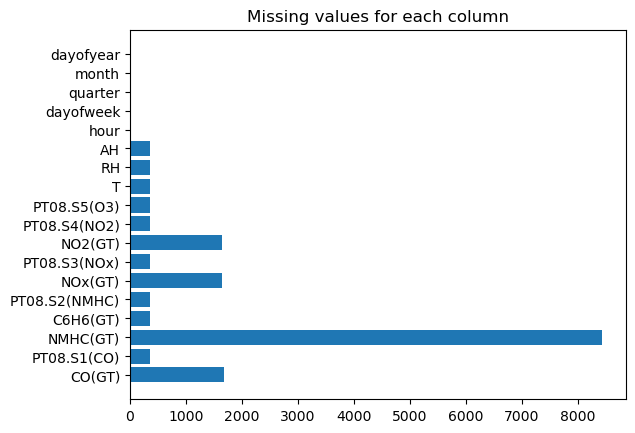

In [54]:
# Histogram of nulls in our Avg. CO data
nulls = df.isnull().sum(axis=0)
plt.barh(y=nulls.keys(), width=nulls.values)
plt.title("Missing values for each column")

Clearly NMHC is useless to us with how much of it is missing.  The CO data is what we want to examine and it is missing hte second most - tied with NO2 and NOx.  As such we will drop the NMHC data and retain the rest for imputation.

In [55]:
df.drop(columns=["NMHC(GT)"], inplace=True)

In [56]:
[x/len(df)*100 for x in nulls]  # % of missing data by column.  The 90% was for NMHC which we got rid of

[17.98845660538692,
 3.9119281744335184,
 90.2415562206071,
 3.9119281744335184,
 3.9119281744335184,
 17.51817015818726,
 3.9119281744335184,
 17.5502351432236,
 3.9119281744335184,
 3.9119281744335184,
 3.9119281744335184,
 3.9119281744335184,
 3.9119281744335184,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

For imputation of numerical variables if the % missing is <10% we'd impute via mean or median depending on if the distribution was symmetric or skewed.  Since we're missing more than that in our target column we'll have to use a different method for better results.

First lets do some EDA

<AxesSubplot:title={'center':'Mean of avg. CO by month'}, xlabel='month'>

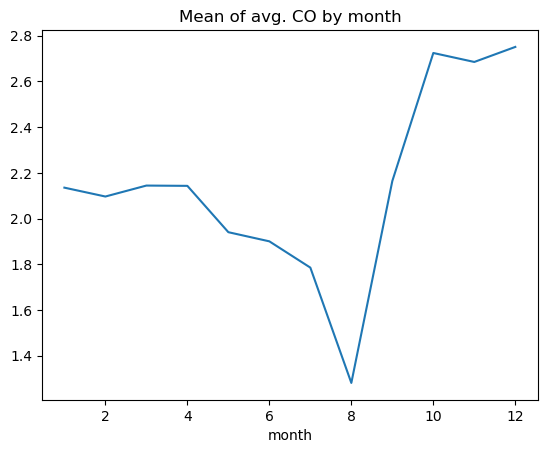

In [57]:
df.groupby('month')['CO(GT)'].mean().plot(title="Mean of avg. CO by month")


Can see CO seems to have a strong correlation to a few of our columns.  Specifically, most of our other chemicals.  Interestingly, there seems to be very little correlation with our date information.

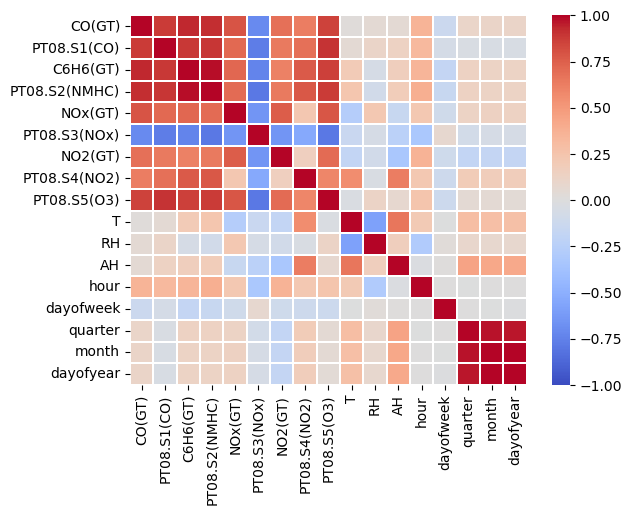

In [58]:
fig = sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.25, yticklabels=True, vmin=-1, vmax=1)

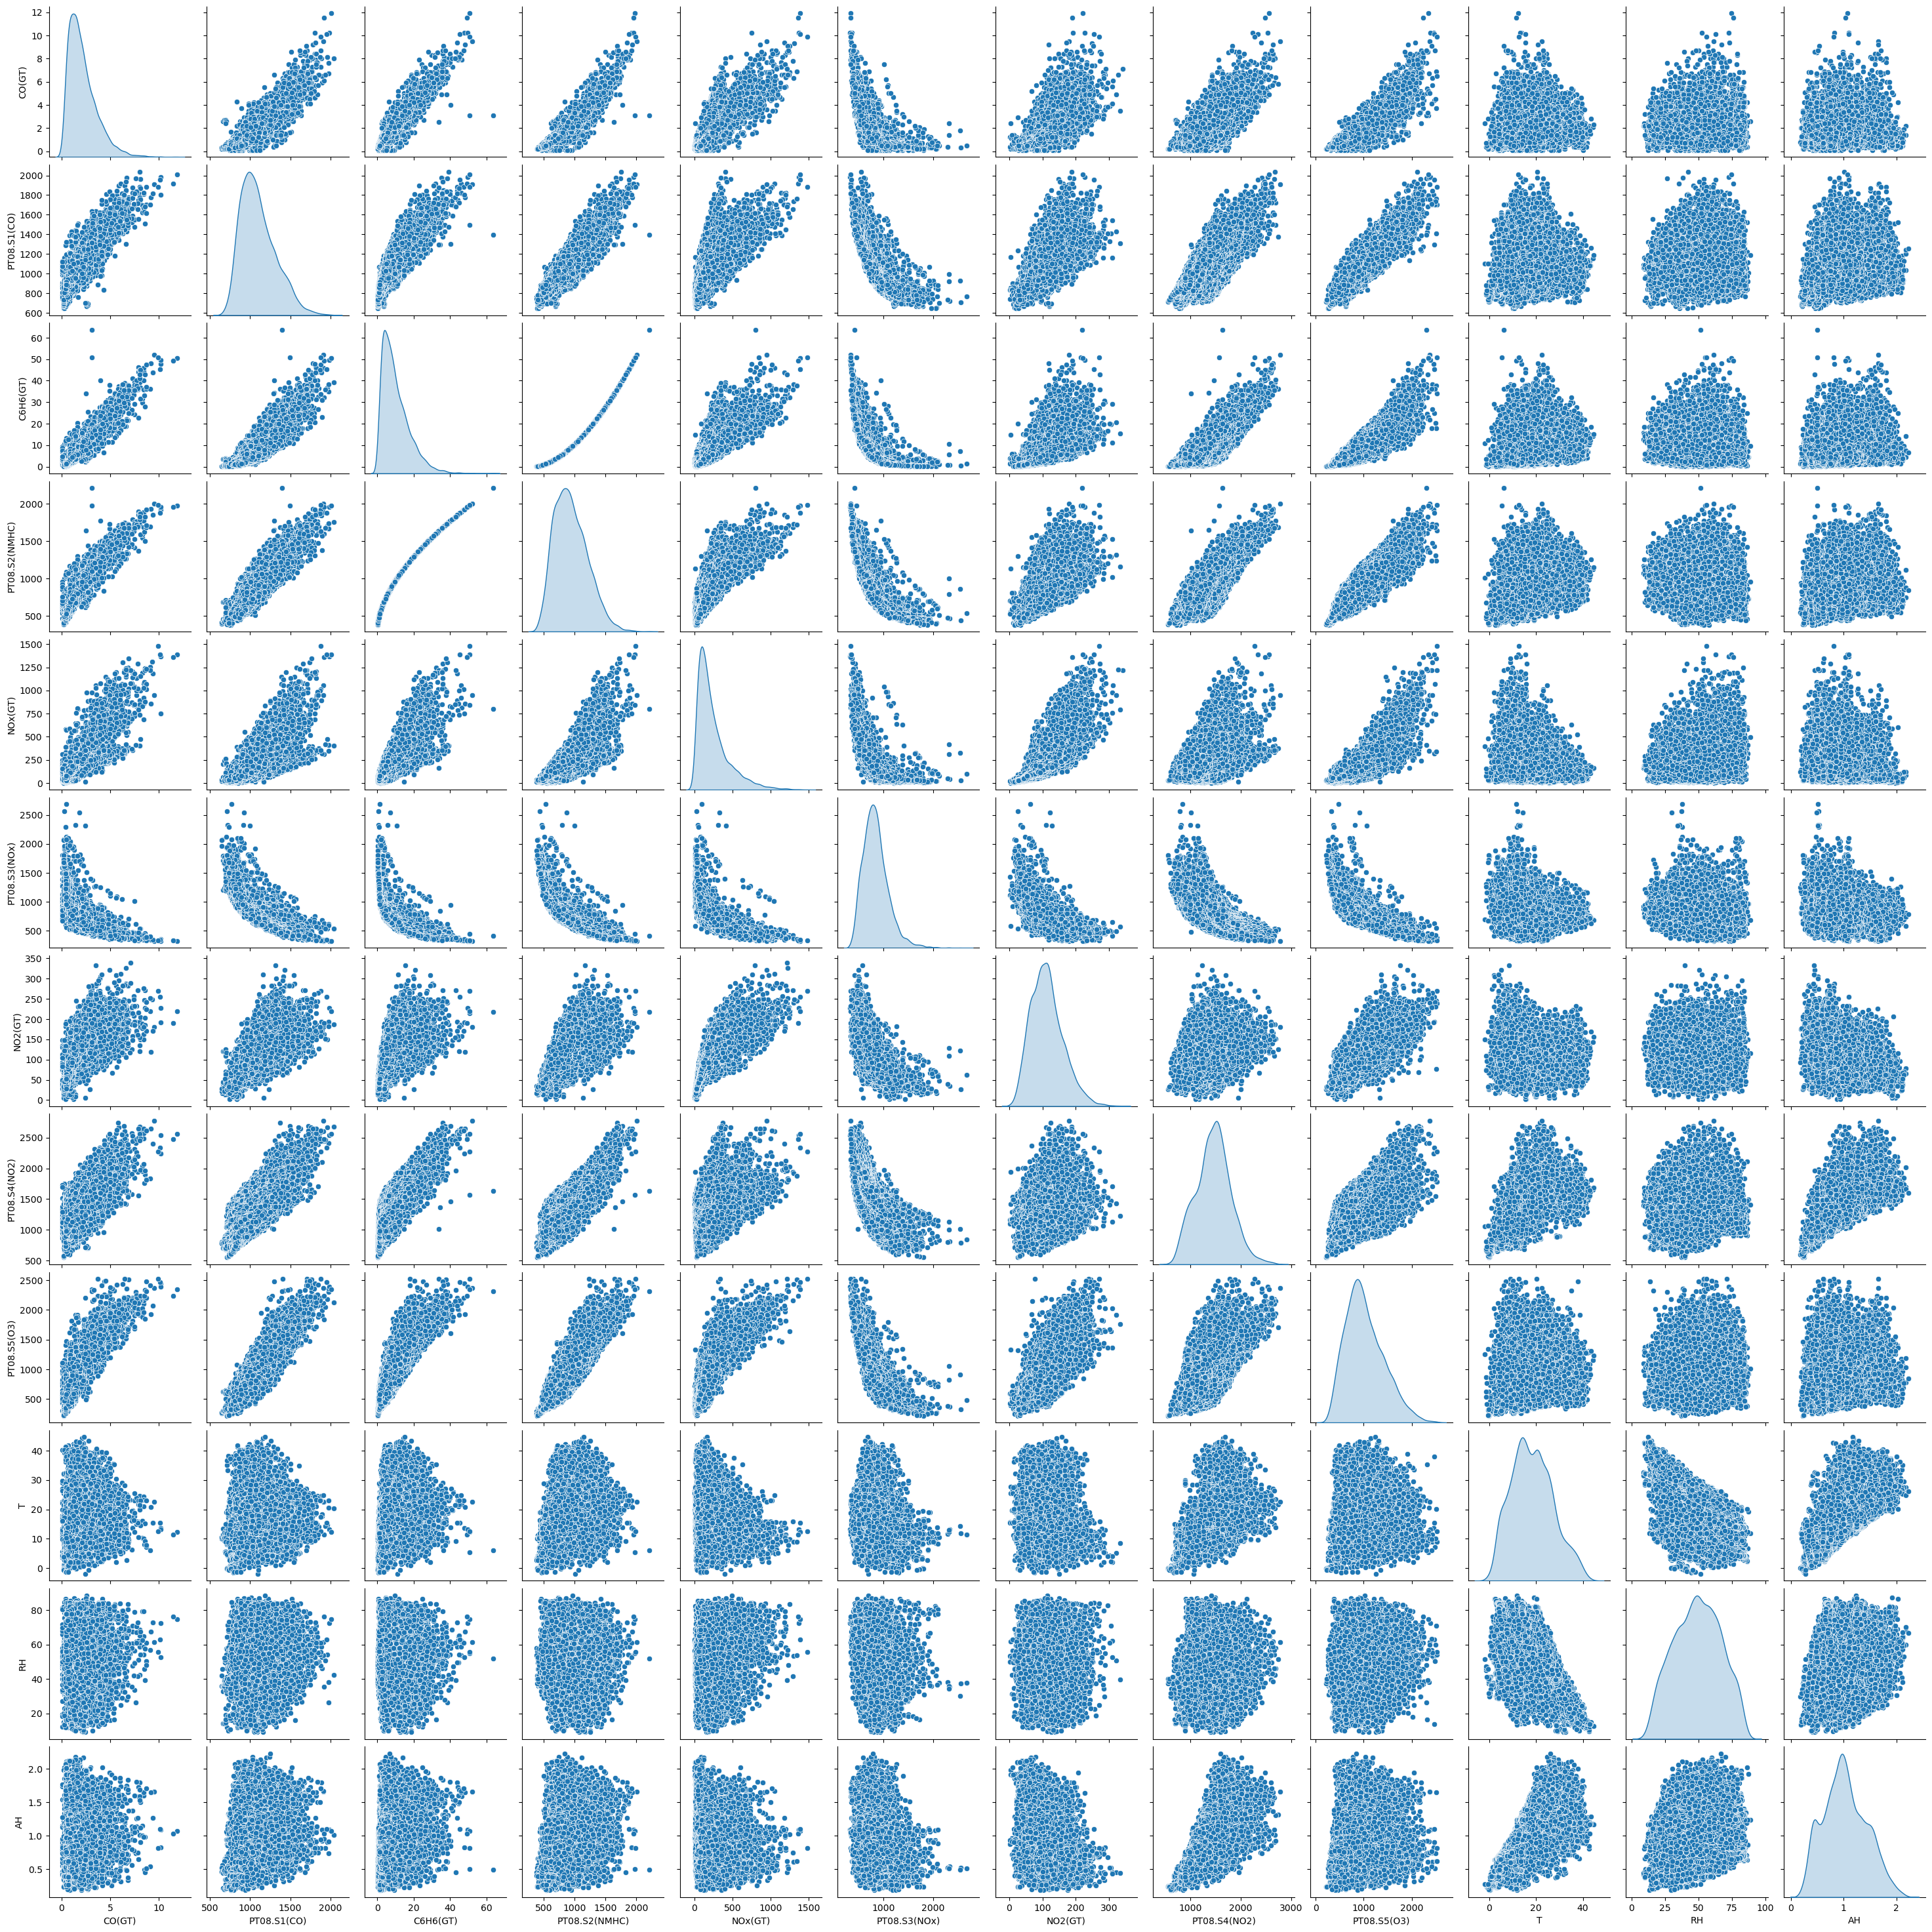

In [30]:
sns.pairplot(df, vars=list(df.columns[:12]), diag_kind='kde')  # Pairplot of non-time features

## Imputation
Impute missing data using sklearn KNNImputer

In [86]:
impdf = df.copy()  
for col in impdf.columns[:12]:  # Skip the time data as that is never missing
    imputer = KNNImputer(n_neighbors=5, weights='uniform')  
    imputedVals = imputer.fit_transform(impdf[[col]])
    impdf[col] = imputedVals  # Replace current values with imputed ones


## SLR
#### Note that our data does in fact break the required assumptions for linear regressions.  This is mostly here for me to play around with sklearn as I had previously only used smf.ols for my regression tasks.  

Lets first do a SLR with sklearn.  We'll try fitting each of our possible predictors.


In [89]:
X_train, X_test, y_train, y_test = train_test_split(impdf.drop('CO(GT)', axis=1), impdf['CO(GT)'], test_size=0.2, random_state=543)

In [104]:
bucket = []
for col in X_train.columns:
    reg = linear_model.LinearRegression()
    reg.fit(X_train[[col]], y_train)
    preds = reg.predict(X_test[[col]])
    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    bucket += [(col, r2, mse)]

In [119]:
bucket.sort(key=lambda x: x[1], reverse=True) 
print(f"By highest R2 value, our best linear model uses {bucket[0][0]} with a R2 of {bucket[0][1]:.4f}")
bucket.sort(key=lambda x: x[2], reverse=False) 
print(f"By lowest MSE, our best linear model uses {bucket[0][0]} with an MSE of {bucket[0][2]:.4f}")

By highest R2 value, our best linear model uses C6H6(GT) with a R2 of 0.6503
By lowest MSE, our best linear model uses C6H6(GT) with an MSE of 0.5915


From our pairplots we could see plenty of evidence of colinearity e.g. in our created time features.  Corr plot from earlier showed evidence of correlation as well.  Our VIF values also show plenty of evidence of correlation with almost all of them >= 5 (indicating highly correlated)

## Time-based cross-validation with sklearn

In [149]:
X = impdf.drop("CO(GT)", axis=1)
y = impdf['CO(GT)']

In [150]:
ts = TimeSeriesSplit(n_splits=5, gap=24)
all_splits = list(ts.split(X,y))

In [151]:
catCols = ['hour', 'dayofweek', 'quarter', 'month', 'dayofyear']
categories = []
for cat in catCols:
    categories.append(list(np.unique(df[cat])))
ordinal_encoder = OrdinalEncoder(categories=categories)

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, catCols),
        ],
        remainder="passthrough",
        # Use short feature names to make it easier to specify the categorical
        # variables in the HistGradientBoostingRegressor in the next
        # step of the pipeline.
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=catCols,
    ),
)

In [152]:
def evalModel(model, X, y, cv):
    cv_results = cross_validate(
        model, X, y, cv=cv, scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
    )
    mae = -cv_results['test_neg_mean_absolute_error']
    rmse = -cv_results['test_neg_root_mean_squared_error']
    print(f"MAE: {mae.mean():.3f} +/- {mae.std():.3f}\n"
          f"RMSE: {rmse.mean():.3f} +/- {rmse.std():.3f}"
          )

In [153]:
evalModel(gbrt_pipeline,X,y,cv=ts)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Zade\anaconda3\envs\py106\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Zade\anaconda3\envs\py106\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\Zade\anaconda3\envs\py106\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py", line 310, in fit
    self.is_categorical_, known_categories = self._check_categories(X)
  File "c:\Users\Zade\anaconda3\envs\py106\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py", line 198, in _check_categories
    raise ValueError(
ValueError: categorical_features must be an array-like of bools or array-like of ints.
